# PyTorch Classification Exercises

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons( n_samples=1000, noise=0.1, random_state=RANDOM_SEED)

In [3]:
# Turn data into a DataFrame
import pandas as pd

df = pd.DataFrame( data=X, columns=[ "x1", "x2"])
df[ "class"] = y

df.head()

,x1,x2,class
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0


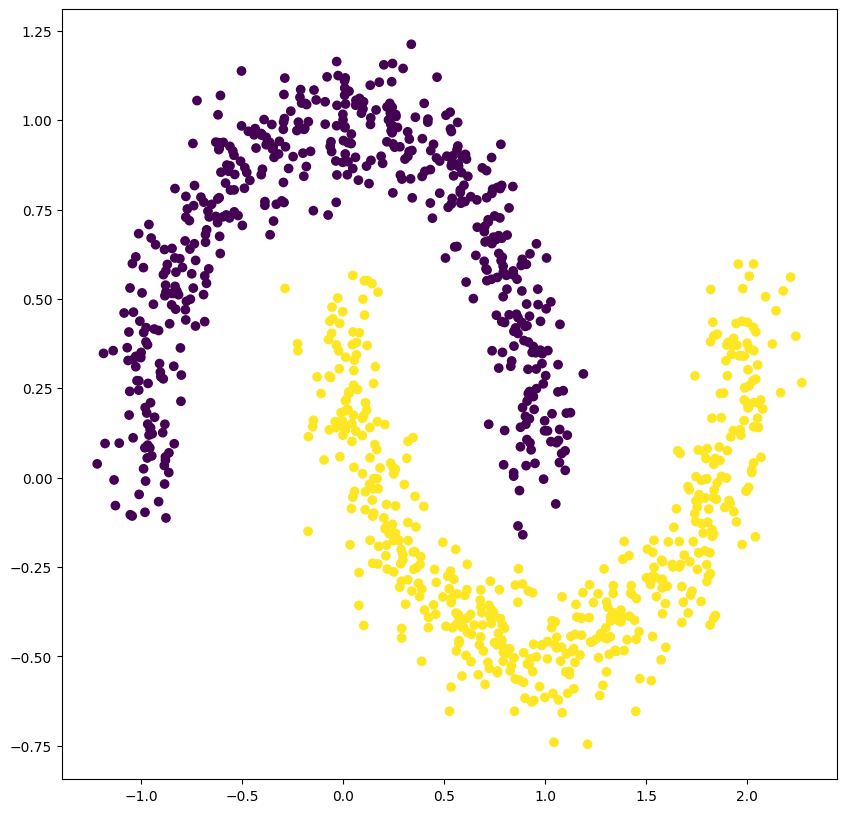

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.figure( figsize=( 10, 10))
plt.scatter( df[ "x1"], df[ "x2"], c=df[ "class"])
plt.show()

In [5]:
# Turn data into tensors of dtype float
X = torch.from_numpy( X).type( torch.float)
y = torch.from_numpy( y).type( torch.float)


# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=RANDOM_SEED)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions

In [6]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0( nn.Module):
	def __init__( self, input_features, output_features, hidden_units=10):
		super().__init__()
        
		self.linear_layer_stack = nn.Sequential(
			nn.Linear( in_features=input_features, out_features=hidden_units),
			nn.ReLU(),
			nn.Linear( in_features=hidden_units, out_features=hidden_units),
			nn.ReLU(),
			nn.Linear( in_features=hidden_units, out_features=output_features)
		)
    

	def forward( self, x):
		return self.linear_layer_stack( x)

# Instantiate the model
model_0 = MoonModelV0(
	input_features=2,
	output_features=1,
	hidden_units=10
).to( device)

model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer

In [7]:
# Setup loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD( params=model_0.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model

In [8]:
# What's coming out of our model?
model_0.eval()

with torch.inference_mode():
	y_logits = model_0( X_test.to( device))[ :5]

y_pred_probs = torch.sigmoid( y_logits)

y_pred = torch.round( y_pred_probs)

# logits (raw outputs of model)
print("Logits:")
print( y_logits)

# Prediction probabilities
print("Pred probs:")
print( y_pred_probs)

# Prediction labels
print("Pred labels:")
print( y_pred)

Logits:
tensor([[-0.1712],
        [-0.2073],
        [-0.1766],
        [-0.2107],
        [-0.1634]], device='cuda:0')
Pred probs:
tensor([[0.4573],
        [0.4484],
        [0.4560],
        [0.4475],
        [0.4592]], device='cuda:0')
Pred labels:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [9]:
# calculuate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

acc_fn = Accuracy( task="multiclass", num_classes=2).to( device)

acc_fn

MulticlassAccuracy()

In [10]:
torch.manual_seed( RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train = X_train.to( device)
y_train = y_train.to( device)

X_test = X_test.to( device)
y_test = y_test.to( device)


# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  train_logits = model_0( X_train).squeeze()
  
  # Turn logits into prediction probabilities
  train_pred_probs = torch.sigmoid( train_logits)

  # Turn prediction probabilities into prediction labels
  train_pred = torch.round( train_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn( train_logits, y_train)

  # Calculate the accuracy
  acc = acc_fn( train_pred, y_train.int())

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() 
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0( X_test).squeeze()
    
	# Turn the test logits into prediction labels
    test_pred = torch.round( torch.sigmoid( test_logits))
	
    # 2. Caculate the test loss/acc
    test_loss = loss_fn( test_logits, y_test)
    test_acc = acc_fn( test_pred, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print( f"Epoch: { epoch} | Loss: { loss:.4f}, Acc: { acc:.2f}% | Test Loss: { test_loss:.4f}, Test Acc: { test_acc:.2f}%")

Epoch: 0 | Loss: 0.6889, Acc: 0.50% | Test Loss: 0.6869, Test Acc: 0.50%
Epoch: 100 | Loss: 0.3045, Acc: 0.86% | Test Loss: 0.3174, Test Acc: 0.85%
Epoch: 200 | Loss: 0.2339, Acc: 0.90% | Test Loss: 0.2306, Test Acc: 0.91%
Epoch: 300 | Loss: 0.2085, Acc: 0.91% | Test Loss: 0.2021, Test Acc: 0.92%
Epoch: 400 | Loss: 0.1789, Acc: 0.92% | Test Loss: 0.1727, Test Acc: 0.92%
Epoch: 500 | Loss: 0.1433, Acc: 0.94% | Test Loss: 0.1371, Test Acc: 0.94%
Epoch: 600 | Loss: 0.1072, Acc: 0.96% | Test Loss: 0.1002, Test Acc: 0.98%
Epoch: 700 | Loss: 0.0776, Acc: 0.98% | Test Loss: 0.0701, Test Acc: 0.99%
Epoch: 800 | Loss: 0.0571, Acc: 0.99% | Test Loss: 0.0496, Test Acc: 0.99%
Epoch: 900 | Loss: 0.0436, Acc: 0.99% | Test Loss: 0.0365, Test Acc: 1.00%


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [11]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

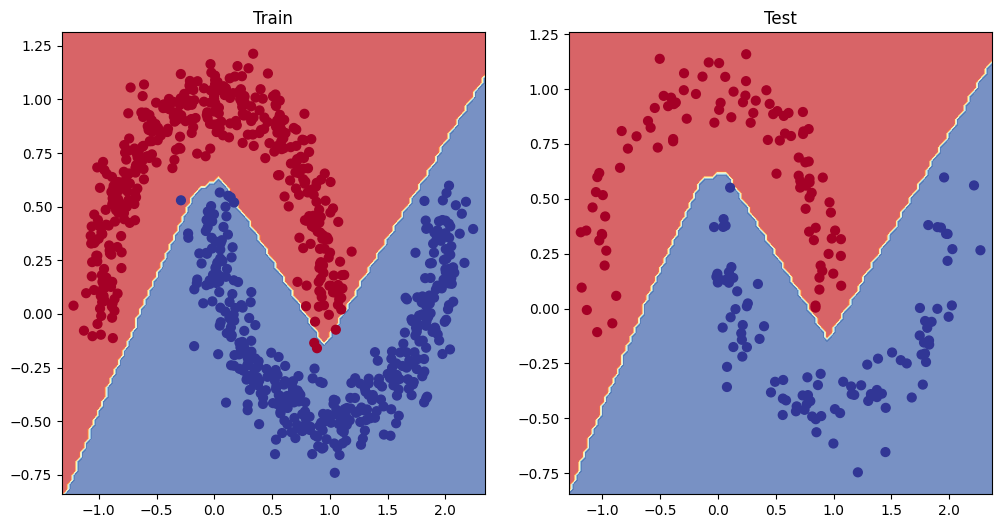

In [12]:
# Plot decision boundaries for training and test sets
plt.figure( figsize=( 12, 6))

plt.subplot( 1, 2, 1)
plt.title( "Train")
plot_decision_boundary( model_0, X_train, y_train)

plt.subplot( 1, 2, 2)
plt.title( "Test")
plot_decision_boundary( model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [13]:
# Create a straight line tensor
l = torch.arange( -10, 10, 1, dtype=torch.float32)

l

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

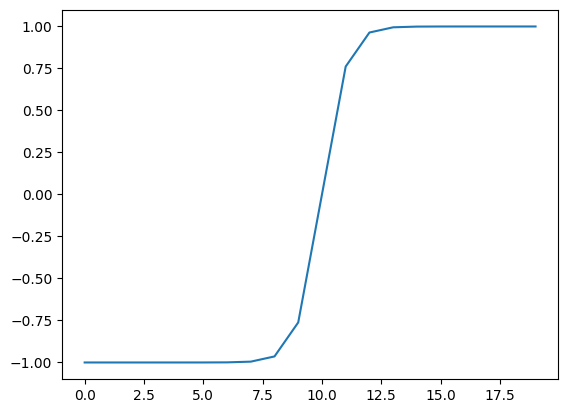

In [14]:
# Test torch.tanh() on the tensor and plot it
plt.plot( torch.tanh( l))
plt.show()

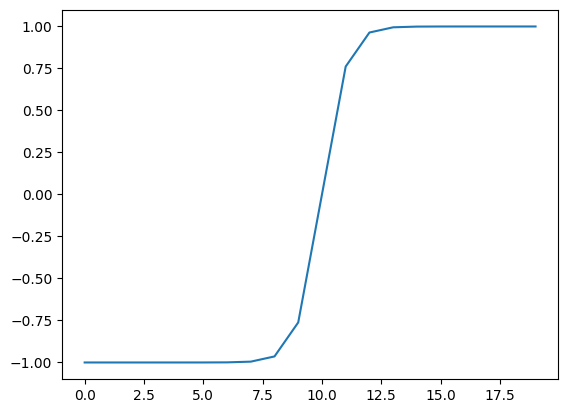

In [15]:
# Replicate torch.tanh() and plot it
def tanh( x: torch.Tensor) -> torch.Tensor:
	return torch.tanh( x)

plt.plot( tanh( l))

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

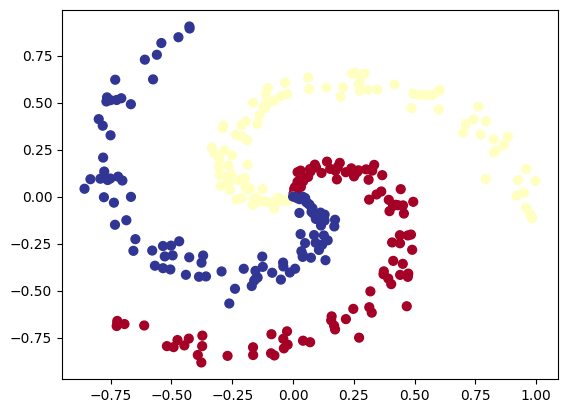

In [16]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [17]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=RANDOM_SEED)


In [18]:
# calculuate the accuracy for when we fit our model
from torchmetrics import Accuracy

acc_fn = Accuracy( task="multiclass", num_classes=4).to( device)
acc_fn

MulticlassAccuracy()

In [19]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModelV0( nn.Module):
	def __init__( self, input_features, output_features, hidden_units=10):
		super().__init__()

		self.layer_stack = nn.Sequential(
			nn.Linear( in_features=input_features, out_features=hidden_units),
			nn.Tanh(),
			nn.Linear( in_features=hidden_units, out_features=hidden_units),
			nn.Tanh(),
			nn.Linear( in_features=hidden_units, out_features=output_features)
		)

	def forward( self, x):
		return self.layer_stack( x)

# Instantiate model and send it to device
model_1 = SpiralModelV0(
	input_features=2,
	output_features=3,
	hidden_units=10
).to( device)

model_1

SpiralModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [20]:
model_1.eval()

with torch.inference_mode():
	y_logits = model_1( X_test[ :10].to( device))

y_pred_probs = torch.softmax( y_logits, dim=1)

y_pred = torch.argmax( y_pred_probs, dim=1)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
print( y_logits)

print("Pred probs:")
print( y_pred_probs)

print("Pred labels:")
print( y_pred)

Logits:
tensor([[-0.2370, -0.1379,  0.0691],
        [-0.1750, -0.0614,  0.0822],
        [-0.2233, -0.0100,  0.1017],
        [-0.2386, -0.1188,  0.0741],
        [-0.2423, -0.2107,  0.0532],
        [-0.2442, -0.1965,  0.0564],
        [-0.3232, -0.2132,  0.0751],
        [-0.2256, -0.1285,  0.0700],
        [-0.2352, -0.1217,  0.0729],
        [-0.2877, -0.0975,  0.0925]], device='cuda:0')
Pred probs:
tensor([[0.2888, 0.3189, 0.3923],
        [0.2929, 0.3282, 0.3789],
        [0.2761, 0.3417, 0.3821],
        [0.2862, 0.3226, 0.3912],
        [0.2962, 0.3057, 0.3981],
        [0.2942, 0.3085, 0.3973],
        [0.2774, 0.3096, 0.4131],
        [0.2902, 0.3198, 0.3900],
        [0.2873, 0.3218, 0.3909],
        [0.2723, 0.3294, 0.3983]], device='cuda:0')
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [21]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( params=model_1.parameters(), lr=0.1)

In [22]:
X_train = X_train.to( device)
y_train = y_train.to( device)

X_test = X_test.to( device)
y_test = y_test.to( device)

epochs = 1000

torch.manual_seed( RANDOM_SEED)
torch.cuda.manual_seed( RANDOM_SEED)

# Build a training loop for the model

# Loop over data
for epoch in range( epochs):
	## Training
	model_1.train()
	
	# 1. Forward pass
	train_logits = model_1( X_train)
	train_pred = torch.softmax( train_logits, dim=1).argmax( dim=1)
	
	# 2. Calculate the loss
	loss = loss_fn( train_logits, y_train)
	acc = acc_fn( train_pred, y_train)
	
	# 3. Optimizer zero grad
	optimizer.zero_grad()
	
	# 4. Loss backward
	loss.backward()
	
	# 5. Optimizer step
	optimizer.step()
	
	## Testing
	model_1.train()

	with torch.inference_mode():
		# 1. Forward pass
		test_logits = model_1( X_test)
		test_pred = torch.softmax( test_logits, dim=1).argmax( dim=1)

		# 2. Caculate loss and acc
		test_loss = loss_fn( test_logits, y_test)
		test_acc = acc_fn( test_pred, y_test)

	# Print out what's happening every 100 epochs
	if epoch % 100 == 0:
		print( f"Epoch: { epoch} | Loss: { loss:.4f}, Acc: { acc:.2f}% | Test Loss: { test_loss:.4f}, Test Acc: { test_acc:.2f}%")

  

Epoch: 0 | Loss: 1.0976, Acc: 0.32% | Test Loss: 1.0887, Test Acc: 0.37%
Epoch: 100 | Loss: 0.8527, Acc: 0.52% | Test Loss: 0.8544, Test Acc: 0.50%
Epoch: 200 | Loss: 0.7539, Acc: 0.52% | Test Loss: 0.7651, Test Acc: 0.50%
Epoch: 300 | Loss: 0.7345, Acc: 0.53% | Test Loss: 0.7479, Test Acc: 0.50%
Epoch: 400 | Loss: 0.7171, Acc: 0.53% | Test Loss: 0.7323, Test Acc: 0.50%
Epoch: 500 | Loss: 0.6934, Acc: 0.55% | Test Loss: 0.7140, Test Acc: 0.52%
Epoch: 600 | Loss: 0.6559, Acc: 0.58% | Test Loss: 0.6860, Test Acc: 0.52%
Epoch: 700 | Loss: 0.6014, Acc: 0.66% | Test Loss: 0.6401, Test Acc: 0.60%
Epoch: 800 | Loss: 0.5398, Acc: 0.73% | Test Loss: 0.5811, Test Acc: 0.65%
Epoch: 900 | Loss: 0.4801, Acc: 0.76% | Test Loss: 0.5181, Test Acc: 0.70%


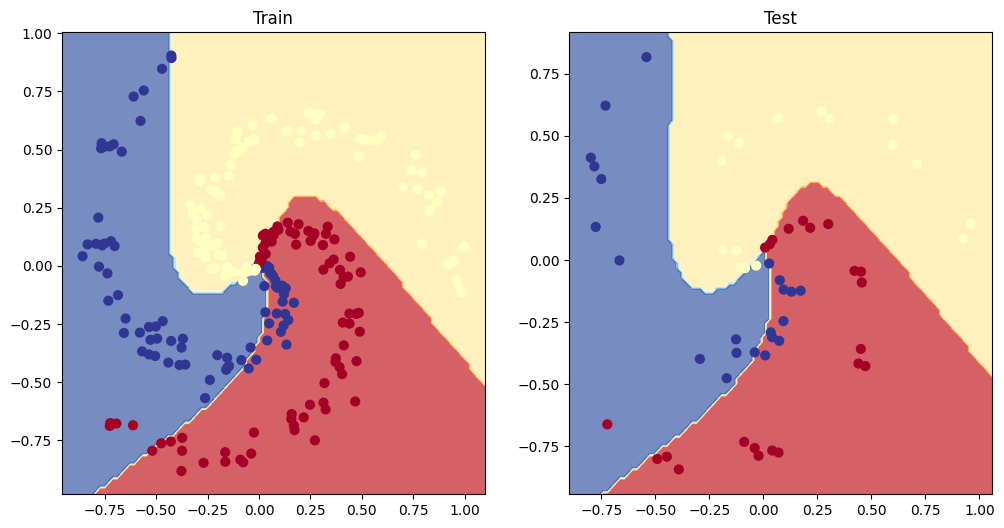

In [23]:
# Plot decision boundaries for training and test sets
plt.figure( figsize=( 12, 6))

plt.subplot( 1, 2, 1)
plt.title( "Train")
plot_decision_boundary( model_1, X_train, y_train)

plt.subplot( 1, 2, 2)
plt.title( "Test")
plot_decision_boundary( model_1, X_test, y_test)